# Binary classification with Neural Networkon the Census Income dataset

**Name :** CHANDRAPRIYADHARSHINI C

**Reg.No :** 212223240019

In [79]:
#import libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [80]:
#Load the dataset
dataset=pd.read_csv('income.csv')

In [81]:
#Check the length of the dataset
print("Length of the Dataset : ",len(dataset))
dataset.head()

Length of the Dataset :  30000


,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [82]:
#How many rows and columns are there in label
dataset['label'].value_counts()

label
0    21700
1     8300
Name: count, dtype: int64

### Separate continuous, categorical and label column names

In [83]:
#Check the dataset columns
dataset.columns

Index(['age', 'sex', 'education', 'education-num', 'marital-status',
       'workclass', 'occupation', 'hours-per-week', 'income', 'label'],
      dtype='object')

In [84]:
categorical_columns = ['sex', 'education', 'marital-status', 'workclass', 'occupation']  # 5 categorical
continuous_columns = ['age', 'hours-per-week']  # 2 continuous
label_column = ['label']  # 1 label

print(f'categorical columns  has {len(categorical_columns)} columns')
print(f'continuos columns has {len(continuous_columns)} columns')
print(f'label column     has {len(label_column)} column')

categorical columns  has 5 columns
continuos columns has 2 columns
label column     has 1 column


### Create arrays and tensors for categorical values, continuous values, and labels.

In [85]:
# Make sure categorical columns are of dtype 'category'
for col in categorical_columns:
    dataset[col] = dataset[col].astype('category')

In [88]:
dataset = shuffle(dataset, random_state=101)
dataset.reset_index(drop=True, inplace=True)

In [89]:
cat_szs = [len(dataset[col].cat.categories) for col in categorical_columns]

In [90]:
# emb_szs: (num_categories, embedding_size). embedding_size rule: (c+1)//2
emb_szs = [(c, (c+1)//2) for c in cat_szs]
print(emb_szs)

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]


In [91]:
# Now create categorical array
categorical = np.stack([dataset[col].cat.codes.values for col in categorical_columns], axis=1)
print(categorical[:5])

[[ 0 10  3  2  6]
 [ 0 12  1  4  7]
 [ 1 13  0  2  0]
 [ 1 10  1  2  1]
 [ 0 13  3  2  9]]


In [92]:
# Convert "conts" to a tensor (float64)
categorical = torch.tensor(categorical, dtype=torch.int64)
print(categorical.dtype)

torch.int64


In [93]:
#Create an array of continuous values
continuous = np.stack([dataset[col].values for col in continuous_columns], axis=1)
print(continuous[:5])

[[23 50]
 [37 39]
 [34 40]
 [31 40]
 [20 25]]


In [94]:
# Convert "conts" to a tensor (float32)
continuous = torch.tensor(continuous, dtype=torch.float32)
print(continuous.dtype)

torch.float32


In [95]:
#Create a label tensor (flattened, long)
label = torch.tensor(dataset[label_column].values.reshape(-1), dtype=torch.long)
print(label.dtype, label.shape)

torch.int64 torch.Size([30000])


### Split the dataset into training and testing sets (use 25,000 for training and 5,000 for testing).

In [97]:
#Create train and test sets from cats, conts, and y
batch = 30000  # batch (entire dataset as exercise)
test = 5000   # test size
train = batch - test  # train size

In [98]:
categorical_train = categorical[:batch - test]
categorical_test  = categorical[batch - test:]

In [99]:
continuous_train = continuous[:batch - test]
continuous_test  = continuous[batch - test:]

In [100]:
label_train = label[:batch - test]
label_test  = label[batch - test:]

In [101]:
print(type(categorical_train), categorical_train.dtype)
print(type(continuous_train), continuous_train.dtype)
print(type(label_train), label_train.dtype)

<class 'torch.Tensor'> torch.int64
<class 'torch.Tensor'> torch.float32
<class 'torch.Tensor'> torch.int64


In [102]:
print(categorical_train.shape, continuous_train.shape, label_train.shape)
print(categorical_test.shape, continuous_test.shape, label_test.shape)

torch.Size([25000, 5]) torch.Size([25000, 2]) torch.Size([25000])
torch.Size([5000, 5]) torch.Size([5000, 2]) torch.Size([5000])


### Define a TabularModel class that takes embeddings for categorical features and batch-normalized continuous features.

In [103]:
#Create a TabularModel instance (one hidden layer with 50 neurons, p=0.4)
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5): #n_cont - no.of continuous features, out_sz - output layer , p - dropout probablity
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #ni - number of categories, nf - embedding size
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

### Create a model with one hidden layer of 50 neurons and dropout p=0.4.

In [104]:
torch.manual_seed(23)

In [105]:
n_cont = len(continuous_columns)
model = TabularModel(emb_szs, n_cont=n_cont, out_sz=2, layers=[50], p=0.4) #Hidden layer of 50 neurons and p=0.4
print(model)

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


### Use CrossEntropyLoss as the criterion and Adam optimizer (lr=0.001).

In [106]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model for 300 epochs.

In [107]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    y_pred = model(categorical_train, continuous_train)
    loss = criterion(y_pred, label_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.82599962
epoch:  26  loss: 0.57647502
epoch:  51  loss: 0.49806967
epoch:  76  loss: 0.45836234
epoch: 101  loss: 0.43528718
epoch: 126  loss: 0.40981343
epoch: 151  loss: 0.39079770
epoch: 176  loss: 0.37956232
epoch: 201  loss: 0.36597317
epoch: 226  loss: 0.35190544
epoch: 251  loss: 0.34172899
epoch: 276  loss: 0.33811206
epoch: 299  loss: 0.32936421

Duration: 40 seconds


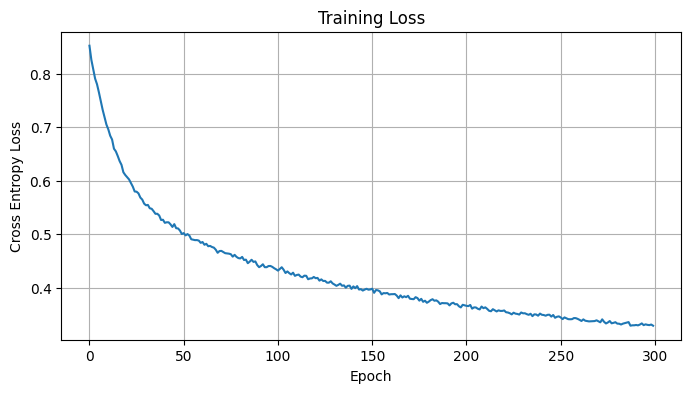

In [108]:
# Plot Cross Entropy Loss vs epochs
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

### Evaluate the test set (Cross Entropy loss on test)

In [109]:
# Evaluate the test set (CE loss on test)
model.eval()
with torch.no_grad():
    y_val = model(categorical_test, continuous_test)
    loss_val = criterion(y_val, label_test)

print(f'CE Loss: {loss_val.item():.8f}')

CE Loss: 0.31363893


### Accuracy

In [110]:
with torch.no_grad():
    preds = torch.argmax(y_val, dim=1)
    correct = (preds == label_test).sum().item()
    total = label_test.size(0)
    acc = correct / total * 100.0
    print(f'{correct} out of {total} = {acc:.2f}% correct')

4330 out of 5000 = 86.60% correct
